<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Iguazio's Online Serving Graphs

In [1]:
import mlrun
project_name = "nlp"
project = mlrun.get_or_create_project(project_name, context="./", user_project=True)

> 2022-05-03 15:28:28,957 [info] created and saved project nlp


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Define your function

In [2]:
fn = mlrun.code_to_function(name="news-article-nlp", 
                            filename="nlp_transformations.py",
                            kind="serving", 
                            image='mlrun/ml-models')
fn.spec.min_replicas = 1
fn.spec.max_replicas = 1
fn.spec.build.commands = [
    "python -m pip install transformers==4.11.3 newspaper3k==0.2.8 keybert==0.5.0",
    "python -c 'from transformers import pipeline; pipeline(\"summarization\")'",
    "python -c 'from keybert import KeyBERT; KeyBERT()'"
]

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Define the pipeline

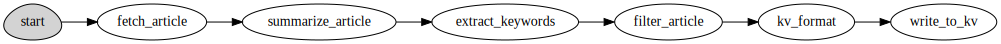

In [3]:
graph = fn.set_topology("flow", engine="async")

graph.to(name="fetch_article", handler="fetch_article")\
     .to(name="summarize_article", class_name="SummarizeArticle")\
     .to(name="extract_keywords", class_name="ExtractKeywords")\
     .to(name="filter_article", handler="filter_article")\
     .to(name="kv_format", handler="kv_format", full_event=True)\
     .to(name="write_to_kv", class_name="storey.NoSqlTarget", table=f"v3io:///bigdata/nlp").respond()

graph.plot(rankdir='LR')

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Test pipeline locally

In [5]:
from nlp_transformations import *

server = fn.to_mock_server()

server.test("/", body={"url" : "https://www.cnn.com/2021/11/01/politics/vaccine-rules-osha/index.html"})

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 41.0kB/s]
Downloading: 100%|██████████| 112/112 [00:00<00:00, 94.5kB/s]
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 2.97MB/s]
Downloading: 100%|██████████| 350/350 [00:00<00:00, 44.8kB/s]
Downloading: 100%|██████████| 13.2k/13.2k [00:00<00:00, 4.16MB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 2.05MB/s]


{'url': 'https://www.cnn.com/2021/11/01/politics/vaccine-rules-osha/index.html',
 'title': 'Emergency vaccine rule for large employers will be issued in the coming days',
 'authors': '["Kaitlan Collins", "Kate Sullivan"]',
 'publish_date': '2021-11-01 00:00:00',
 'summarized_text': ' The Federal Register will publish the Labor Departments emergency temporary standard in the coming days . The rule requires private businesses with 100 or more employees to vaccinate or test them weekly . President Joe Biden announced the rule in September . Employers must develop, implement, and enforce a mandatory COVID-19 vaccination policy .',
 'keywords': '["vaccination", "compliance", "announced", "biden", "emergency"]'}

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Deploy our pipeline to the cluster

In [6]:
fn.deploy()

> 2022-05-03 15:41:20,104 [info] Starting remote function deploy
2022-05-03 19:41:20  (info) Deploying function
2022-05-03 19:41:20  (info) Building
2022-05-03 19:41:20  (info) Staging files and preparing base images
2022-05-03 19:41:20  (info) Building processor image
2022-05-03 19:44:04  (info) Build complete
2022-05-03 19:44:19  (info) Function deploy complete
> 2022-05-03 15:44:20,558 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-nlp-brennan-news-article-nlp.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['nlp-brennan-news-article-nlp-nlp-brennan.default-tenant.app.us-sales-322.iguazio-cd1.com/']}


'http://nlp-brennan-news-article-nlp-nlp-brennan.default-tenant.app.us-sales-322.iguazio-cd1.com/'

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Programmatically test our live endpoint

In [8]:
fn.invoke(
    path="/",
    body={"url" : "https://www.cnn.com/2021/11/01/politics/vaccine-rules-osha/index.html"}
)

> 2022-05-03 15:44:41,116 [info] invoking function: {'method': 'POST', 'path': 'http://nlp-brennan-news-article-nlp-nlp-brennan.default-tenant.app.us-sales-322.iguazio-cd1.com//'}


{'url': 'https://www.cnn.com/2021/11/01/politics/vaccine-rules-osha/index.html',
 'title': 'Emergency vaccine rule for large employers will be issued in the coming days',
 'authors': '["Kaitlan Collins", "Kate Sullivan"]',
 'publish_date': '2021-11-01 00:00:00',
 'summarized_text': ' The Federal Register will publish the Labor Departments emergency temporary standard in the coming days . The rule requires private businesses with 100 or more employees to vaccinate or test them weekly . President Joe Biden announced the rule in September . Employers must develop, implement, and enforce a mandatory COVID-19 vaccination policy .',
 'keywords': '["vaccination", "compliance", "announced", "biden", "emergency"]'}